# What characteristics correlate with Voting Rate
A friend of mine running for the local council has procured the voter registration data for the area and shared it with me. Here is an initial investigation of voter characteristics and how they correlate with Voting Rate.

Prior to this analysis the data has been cleaned, all personally identifying data removed and some additional featured created by manipulating the available information.

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from modules.lv_utils import load_households
from modules.lv_utils import load_voters

In [2]:
# load the data
households = load_households('data_clean/20180628_fullset_households_district3.csv')
voters = load_voters('data_clean/20180628_fullset_voters_district3.csv')
elections = pd.read_csv('data_clean/20180621_election_data.csv')

# set parameters for vote rate columns for the individual and household levels
cols_vr = ['E34_nVotesPct', 'E56_nVotesPct', 'E78_nVotesPct']
cols_vr_hh = ['E34_nVotesPctInHH','E56_nVotesPctInHH','E78_nVotesPctInHH']

Defining various methods and functions used to present the data.

In [3]:
def vote_data_plus_fields(fields, inc_HHvd=False, inc_Vid=True):
    """
    Returns the voter rate columns with requested fields in a dataframe.
    All fields have missing values replaced with NaNs.
    """
    # including the vote rate household fields if requested
    vr = cols_vr + cols_vr_hh if inc_HHvd else cols_vr
    
    # including the 'Vid' field if requested
    cols = vr + ['Vid'] + fields if inc_Vid else vr + fields
    
    # creating the df requested
    df = voters.loc[:, cols]
    
    # converting cleaned not known data ie 'UNK' to NaNs
    for f in fields:
        # replacing 'UNK' with Nan to indicate no data if fields has any 'UNK'
        if 'UNK' in df.loc[:,f].value_counts().index.values.astype(str):
            df.loc[:,f].replace('UNK', np.NaN, inplace=True)
    
    # replacing '-1' indicating no data for vote with NaN
    for c in df[vr]:
        df[c].replace(-1, np.NaN, inplace=True)
        
    return df

In [4]:
def vote_rate_as_pct(df, prefix):
    """
    Calculates the vote rates as a % of the voters in that group.
    ie what % of E34 voters are a 0 vote rate, and what % have 0.5 and what have a 1.
    prints out the number of voters in each group - ie the sample size.
    """
    out = []
    print('{} has:'.format(prefix))
    for i,f in enumerate(['E34_nVotesPct','E56_nVotesPct','E78_nVotesPct']):
        fcount = df[f].count()
        out.append(df[[f,'Vid']].groupby(f).agg('count')/fcount)
        out[i] = out[i].reset_index().rename(columns={f:'VoteRate', 
                                                      'Vid': prefix+'_'+f[:4]+'Votes'})
        out[i].VoteRate = round(out[i].VoteRate,2).astype('str')
        print('    n = {} for {} data'.format(fcount, f[:3]))
    
    return  pd.merge(
                pd.merge(out[0],out[1], on='VoteRate', how='outer'),
                    out[2], on='VoteRate', how='outer').set_index('VoteRate').sort_index()

In [5]:
def plot_groups(df, title):
    """
    Takes in a list of dataframes and plots a bar chart of the data against voterate
    Each df contains the data for each of the three main vote rates. 
    One dataframe for each group you want to compare.
    """
    colors = [('lightblue','lightskyblue','deepskyblue'),
              ('palegreen','mediumseagreen','forestgreen'),
              ('navajowhite','orange','darkorange'),
              ('lightgrey','silver','darkgrey')]
    offsets = {2:[(-2,0,2),(-3,-1,1)],
               4:[(-6,-2,2),(-5,-1,3),(-4,0,4),(-3,1,5)]}
    ndfs = len(df)
    widths = {2:0.015,
              4:0.01}
    
    fig, ax = plt.subplots()

    for i, d in enumerate(df):
        w = widths[ndfs]
        shs = offsets[ndfs][i]
        cs = colors[i]
        for j, dd in enumerate([d[[c]].dropna() for c in d.columns]):
            sh = shs[j]*w
            ax.bar(dd.index.astype('float')+sh, dd.iloc[:,0],
                   w, alpha=0.7, align='edge', label=dd.columns[0], color=cs[j])

    plt.legend(bbox_to_anchor=(0.75,1))
    plt.ylabel('%of Voters in group')
    plt.xlabel('Vote Rate (1 is always vote, 0 is never votes)')
    plt.title(title)
    plt.show()

In [6]:
def vote_rate_diff_always_never_two_groups(df, prefix):
    """
    Takes in a list of two dataframes and presents the difference between them.
    """
    [df1,df2] = [d.loc[['0.0','1.0'],:] for d in df]
    df1.columns = [c.replace(prefix[0],'') for c in df1.columns]
    df2.columns = [c.replace(prefix[1],'') for c in df2.columns]
    return df1-df2

In [7]:
def plot_hist_vote_rate_vs_field(ax, df, voteRatef, field):
    """
    Spliting the provided data into sometimes, always and never voters and drawing 
    a histogram of the three vote categories on the provided axis.
    """
    a, b = 0.3, 16
    df1 = pd.DataFrame(df[[voteRatef, field]]).rename(columns = {voteRatef:'VR'})
    always, sometimes, never = (df1.VR == 1), (df1.VR < 1) & (df1.VR > 0), (df1.VR == 0)
    
    ax.hist(df1.loc[sometimes, field], bins=b, alpha=a, label='SomeTimesVoters')
    ax.hist(df1.loc[always, field], bins=b, alpha=a, label='AlwaysVoters')
    ax.hist(df1.loc[never, field], bins=b, alpha=a, label='NeverVoters')
    
    ax.legend(loc='upper left')
    return ax

## All Voters in our dataset

In [8]:
print('Our data covers one district, containing information about {} Voters and {} Households.'.format(
        voters.shape[0], households.shape[0]))

Our data covers one district, containing information about 13307 Voters and 6930 Households.


To illuminate voting behavior and allow future development of trainable models predicting vote rate, the vote rate was Calculated on a scale of 0-1 from the data available. 1 is 'always' voted, 0 is never voted, and numbers in between indicate likelihood to vote, higher is more likely.

- E34 data is Vote Rate calculated from the 2012 Primary and General elections only (this was a presidential year).
- E56 data is Vote Rate calculated from the 2012 & 2014 Primary and General elections (so votes from both a presidential year and a congressional year).
- E78 data is Vote Rate calculated from the 2012, 2014 & 2016 Primary and General elections so data from voting habits of up to 6 elections.

Not all currently registered voters were also registered in this same district in 2012, and conversely we only have data from 2012 from voters who are still registered in this district. The data about 2012 voting habits has, as expected, therefore the smallest number of data points.

In [9]:
df = vote_data_plus_fields([])
df = vote_rate_as_pct(df, 'all_voters')

all_voters has:
    n = 9303 for E34 data
    n = 10043 for E56 data
    n = 12378 for E78 data


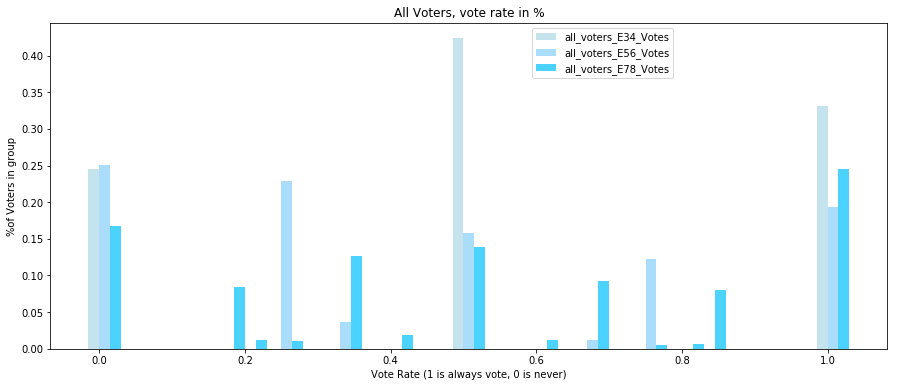

VoteRate,0.0,0.17,0.2,0.25,0.33,0.4,0.5,0.6,0.67,0.75,0.8,0.83,1.0
all_voters_E34_Votes,0.245405,NaN,NaN,NaN,NaN,NaN,0.423734,NaN,NaN,NaN,NaN,NaN,0.330861
all_voters_E56_Votes,0.250921,NaN,NaN,0.228318,0.036443,NaN,0.157324,NaN,0.012048,0.122075,NaN,NaN,0.192871
all_voters_E78_Votes,0.167555,0.084182,0.011634,0.010503,0.126434,0.018258,0.139279,0.011391,0.092422,0.005170,0.007109,0.080304,0.245759


In [10]:
plt.rcParams["figure.figsize"] = (15,6)
fig, ax = plt.subplots()
cs = ('lightblue','lightskyblue','deepskyblue')
w = 0.015
shs = (-1,0,1)
for idx, dd in enumerate([df[[c]].dropna() for c in df.columns]):
    sh = shs[idx]*w
    #ax.bar(dd.index.astype('float')+sh, dd.iloc[:,0])
    ax.bar(dd.index.astype('float')+sh, dd.iloc[:,0], 
           w, alpha=0.7, align='edge', label=dd.columns[0], color=cs[idx])

plt.legend(bbox_to_anchor=(0.75,1))
plt.ylabel('%of Voters in group')
plt.xlabel('Vote Rate (1 is always vote, 0 is never)')
plt.title('All Voters, vote rate in %')
plt.show()

df.transpose()

As expected we get a more spread distribution the more years of election data we use when calculating vote rate.

You can also see that almost half the voters we have 2012 information for sometimes voted and sometimes didn't - likely they voted in the general but not the primary (open primary system in CA started in 2010).

You can also see in the E56 data which has one presidential year and one congressional year of vote behavior included a greater % of voters have lower probabilities of voting. 25% of voters are never voters and 22% have only voted once in the 4 elections in this calculation.

Fewer people vote in congressional cycles.

## How does Age affect vote rate (aka BirthYear)

In [11]:
df = vote_data_plus_fields(['BirthYear'])
old = df.BirthYear < 1901
young = df.BirthYear > 1995
#print(df[old | young].BirthYear.value_counts().sort_index())
print('There are {} people over 100 (inc {} people entering 1900 which is likely bad data)'.format(
df[df.BirthYear < 1918].BirthYear.count(),df[df.BirthYear == 1900].BirthYear.count()))
print('As you would expect some people ({}) register as they turn 18'.format(
df[df.BirthYear == 2000].BirthYear.count()))

print('\nThe {} voters who have 1900 entered for their BirthYears have been removed'.format(
df[old].BirthYear.count()))
# cutting out the outliers
df = df[~old]

There are 12 people over 100 (inc 7 people entering 1900 which is likely bad data)
As you would expect some people (32) register as they turn 18

The 7 voters who have 1900 entered for their BirthYears have been removed


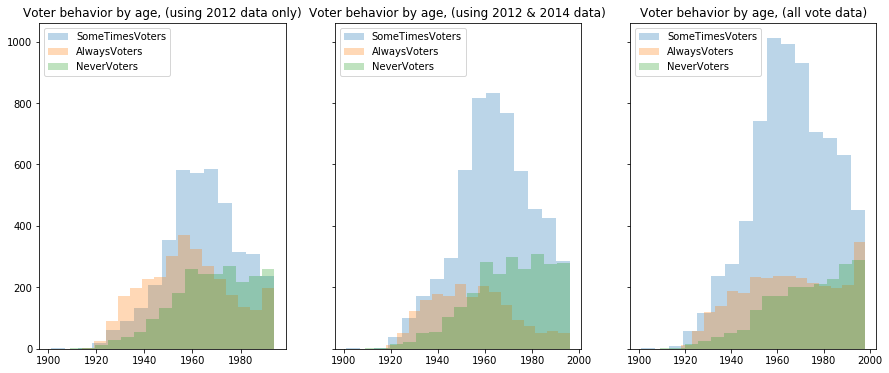

In [12]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, sharey=True)
ax1 = plot_hist_vote_rate_vs_field(ax1, df, 'E34_nVotesPct', 'BirthYear')
ax1.set_title('Voter behavior by age, (using 2012 data only)')

ax2 = plot_hist_vote_rate_vs_field(ax2, df, 'E56_nVotesPct', 'BirthYear')
ax2.set_title('Voter behavior by age, (using 2012 & 2014 data)')

ax3 = plot_hist_vote_rate_vs_field(ax3, df, 'E78_nVotesPct', 'BirthYear')
ax3.set_title('Voter behavior by age, (all vote data)')

plt.show()

You can see in these histograms that the Always Voters skew older (having birth years to the left of the graphs) and the Never Voters skew younger with birth years to the right of the graphs.

You can also see that the young were particularly likely to drop out of the Always vote group during the congressional cycle in 2014.

## Grouping the voters by hasParty

In [13]:
df = vote_data_plus_fields(['HasParty'])
dfm = []
pre = ['noParty', 'hasParty']
for key, grp in df.groupby(['HasParty']):
    dfm.append(vote_rate_as_pct(grp, pre[key]))

noParty has:
    n = 2605 for E34 data
    n = 2903 for E56 data
    n = 3794 for E78 data
hasParty has:
    n = 6698 for E34 data
    n = 7140 for E56 data
    n = 8584 for E78 data


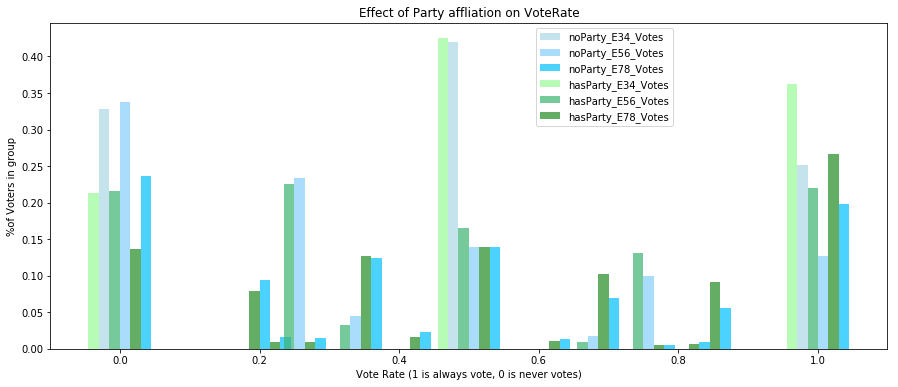

VoteRate,0.0,0.17,0.2,0.25,0.33,0.4,0.5,0.6,0.67,0.75,0.8,0.83,1.0
noParty_E34_Votes,0.328215,NaN,NaN,NaN,NaN,NaN,0.420345,NaN,NaN,NaN,NaN,NaN,0.251440
noParty_E56_Votes,0.337926,NaN,NaN,0.233896,0.044437,NaN,0.139166,NaN,0.017568,0.099552,NaN,NaN,0.127454
noParty_E78_Votes,0.236690,0.094623,0.016342,0.014760,0.124671,0.022404,0.139167,0.013706,0.069584,0.005799,0.008698,0.055614,0.197944
hasParty_E34_Votes,0.213198,NaN,NaN,NaN,NaN,NaN,0.425052,NaN,NaN,NaN,NaN,NaN,0.361750
hasParty_E56_Votes,0.215546,NaN,NaN,0.226050,0.033193,NaN,0.164706,NaN,0.009804,0.131232,NaN,NaN,0.219468
hasParty_E78_Votes,0.136999,0.079567,0.009553,0.008621,0.127213,0.016426,0.139329,0.010368,0.102516,0.004893,0.006407,0.091216,0.266892


In [14]:
plot_groups(dfm, 'Effect of Party affliation on VoteRate')
pd.concat([d for d in dfm], axis=1).transpose()

In [15]:
print('% noParty voters - % hasParty voters')
print('    for the never vote and always vote voters ')
vote_rate_diff_always_never_two_groups(dfm, pre)

% noParty voters - % hasParty voters
    for the never vote and always vote voters 


,_E34_Votes,_E56_Votes,_E78_Votes
VoteRate,,,
0.0,0.115017,0.122380,0.099690
1.0,-0.110310,-0.092013,-0.068948


You can see that blue (noParty) bars are taller on the left of the graph and green (hasParty) bars are taller on the right of the graph. Looking at bar sizes you can see that a voter with an a party affiliation is ~10% more likely to be an always voter group and 10% less likely to be a never voter. 

Note for the hasParty flag people with 'UNK' party affiliation were marked 'False' or noParty.

## Grouping by PartyMain

In [16]:
df = vote_data_plus_fields(['PartyMain'])
# renaming to enable alpha sort to put DEM and REP next to each other
df['PartyMain'].replace('REP', 'EREP', inplace=True)

dfm = []
for key, grp in df.groupby(['PartyMain']):
    dfm.append(vote_rate_as_pct(grp, key))

DEM has:
    n = 4702 for E34 data
    n = 5057 for E56 data
    n = 6232 for E78 data
EREP has:
    n = 1650 for E34 data
    n = 1703 for E56 data
    n = 1865 for E78 data
NPP has:
    n = 2597 for E34 data
    n = 2894 for E56 data
    n = 3781 for E78 data
OTH has:
    n = 346 for E34 data
    n = 380 for E56 data
    n = 487 for E78 data


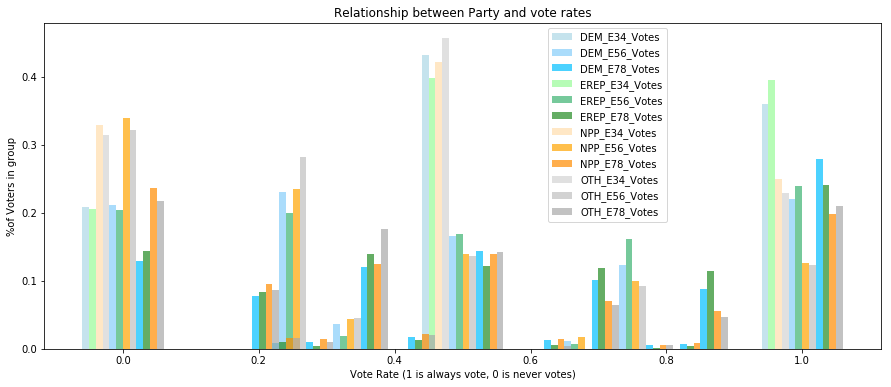

,0.0,0.17,0.2,0.25,0.33,0.4,0.5,0.6,0.67,0.75,0.8,0.83,1.0
DEM_E34_Votes,0.208209,NaN,NaN,NaN,NaN,NaN,0.431944,NaN,NaN,NaN,NaN,NaN,0.359847
DEM_E56_Votes,0.211390,NaN,NaN,0.230769,0.037176,NaN,0.165513,NaN,0.011272,0.123789,NaN,NaN,0.220091
DEM_E78_Votes,0.128851,0.077985,0.008825,0.009949,0.119865,0.017169,0.144416,0.012356,0.100610,0.005777,0.007542,0.087612,0.279044
EREP_E34_Votes,0.206061,NaN,NaN,NaN,NaN,NaN,0.398788,NaN,NaN,NaN,NaN,NaN,0.395152
EREP_E56_Votes,0.204345,NaN,NaN,0.199648,0.018790,NaN,0.168526,NaN,0.007634,0.162067,NaN,NaN,0.238990
EREP_E78_Votes,0.143164,0.083110,0.010188,0.003753,0.138874,0.012869,0.121716,0.005362,0.119035,0.001609,0.004290,0.114745,0.241287
NPP_E34_Votes,0.328841,NaN,NaN,NaN,NaN,NaN,0.421255,NaN,NaN,NaN,NaN,NaN,0.249904
NPP_E56_Votes,0.338977,NaN,NaN,0.234278,0.043884,NaN,0.139254,NaN,0.017277,0.099516,NaN,NaN,0.126814
NPP_E78_Votes,0.236974,0.094684,0.016398,0.014811,0.125099,0.021952,0.139381,0.013753,0.069558,0.005554,0.008463,0.055805,0.197567
OTH_E34_Votes,0.315029,NaN,NaN,NaN,NaN,NaN,0.456647,NaN,NaN,NaN,NaN,NaN,0.228324


In [17]:
title = 'Relationship between Party and vote rates'
plot_always_never_only = False

if plot_always_never_only:
    # plot of always and never voters only:
    tdf = [d.loc[['0.0','1.0'],:] for d in dfm]
    plot_groups(tdf, title)
else:
    # plot of all vote rates:
    plot_groups(dfm, title)

pd.concat([d for d in dfm], axis=1, sort=True).transpose()

You can see clearly that having a party preference of one of the two main parties increases your likelihood of always voting (blue and green taller on right of graph, gray taller on left of graph). The affect is much less marked if you are a member of one of the minor parties, and having No Party Preference means you are most likely to be a never voter, 23% to 33% of NPP voters never vote.

You can also see that across the board there is less voting in the congressional years. 

It is also interesting to notice that a larger share of Rep's were always voters in the 2012 cycle while a larger share of Dem's were in the 2016 cycle this is probably the 'energized' effect of having a sitting president you want to unseat.

Note the NPP number are slightly different to the earlier HasParty analysis as this data removed the 27 'UNK' rather than assumed they were NPP's.

Cohort vote rate calculations would help bring out the effects of the election cycle in the data.

## Full Correlation Matrix of Household characteristics

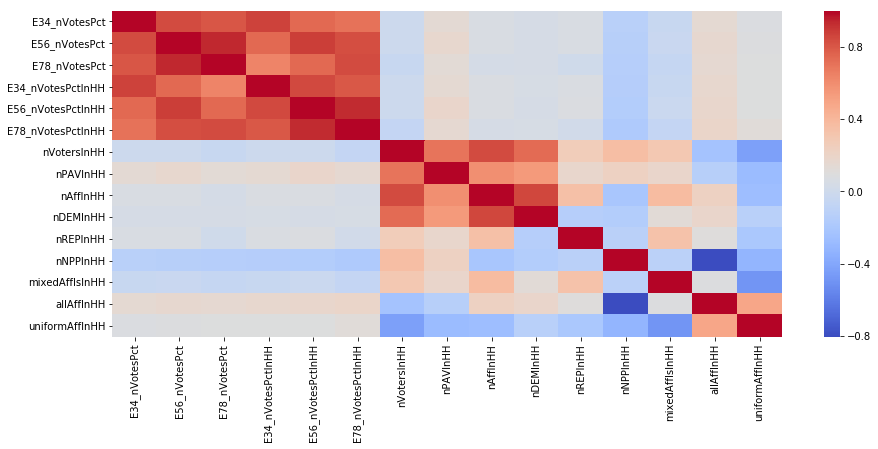

In [18]:
df = vote_data_plus_fields(['nVotersInHH','nPAVInHH','nAffInHH','nDEMInHH','nREPInHH','nNPPInHH',
                            'mostAfflsInHH','mixedAfflsInHH','allAffInHH','uniformAffInHH'],
                            inc_HHvd = True, inc_Vid=False)
# plot the heatmap
sns.heatmap(df.corr(), 
        xticklabels=df.corr().columns,
        yticklabels=df.corr().columns, cmap='coolwarm')
plt.show()

You can see a slight positive correlation with voting for Permanent Absentee Voters, and living in a HH where everyone is affiliated with a party. You can see slight negative correlations with the number of people with No Party Preference, and living in mixed Affiliated households. There is also a slight negative correlation with the over all number of voters in your household.

In [19]:
df.corr()

,E34_nVotesPct,E56_nVotesPct,E78_nVotesPct,E34_nVotesPctInHH,E56_nVotesPctInHH,E78_nVotesPctInHH,nVotersInHH,nPAVInHH,nAffInHH,nDEMInHH,nREPInHH,nNPPInHH,mixedAfflsInHH,allAffInHH,uniformAffInHH
E34_nVotesPct,1.000000,0.843985,0.804988,0.871113,0.741618,0.707058,-0.008784,0.144556,0.066193,0.047330,0.064150,-0.125954,-0.035795,0.148626,0.081222
E56_nVotesPct,0.843985,1.000000,0.937424,0.742861,0.887154,0.833945,-0.013671,0.175707,0.063595,0.043754,0.067610,-0.129836,-0.031109,0.162409,0.085564
E78_nVotesPct,0.804988,0.937424,1.000000,0.636085,0.741332,0.843682,-0.037855,0.138059,0.040014,0.048880,0.010542,-0.136764,-0.050570,0.159256,0.092429
E34_nVotesPctInHH,0.871113,0.742861,0.636085,1.000000,0.849744,0.801297,-0.011247,0.153921,0.074126,0.051936,0.076342,-0.147917,-0.041312,0.171205,0.097387
E56_nVotesPctInHH,0.741618,0.887154,0.741332,0.849744,1.000000,0.929707,-0.012976,0.184958,0.072659,0.047870,0.082730,-0.148792,-0.028127,0.181913,0.095743
E78_nVotesPctInHH,0.707058,0.833945,0.843682,0.801297,0.929707,1.000000,-0.056542,0.156195,0.043213,0.050556,0.019693,-0.174242,-0.060844,0.193822,0.120575
nVotersInHH,-0.008784,-0.013671,-0.037855,-0.011247,-0.012976,-0.056542,1.000000,0.698352,0.838194,0.733060,0.266372,0.359379,0.301742,-0.228634,-0.431356
nPAVInHH,0.144556,0.175707,0.138059,0.153921,0.184958,0.156195,0.698352,1.000000,0.598405,0.542334,0.177411,0.228002,0.187943,-0.133220,-0.277974
nAffInHH,0.066193,0.063595,0.040014,0.074126,0.072659,0.043213,0.838194,0.598405,1.000000,0.855793,0.346693,-0.206162,0.378784,0.231490,-0.264225
nDEMInHH,0.047330,0.043754,0.048880,0.051936,0.047870,0.050556,0.733060,0.542334,0.855793,1.000000,-0.139735,-0.149048,0.127430,0.184199,-0.125493


## Full Correlation Matrix of Voter characteristics

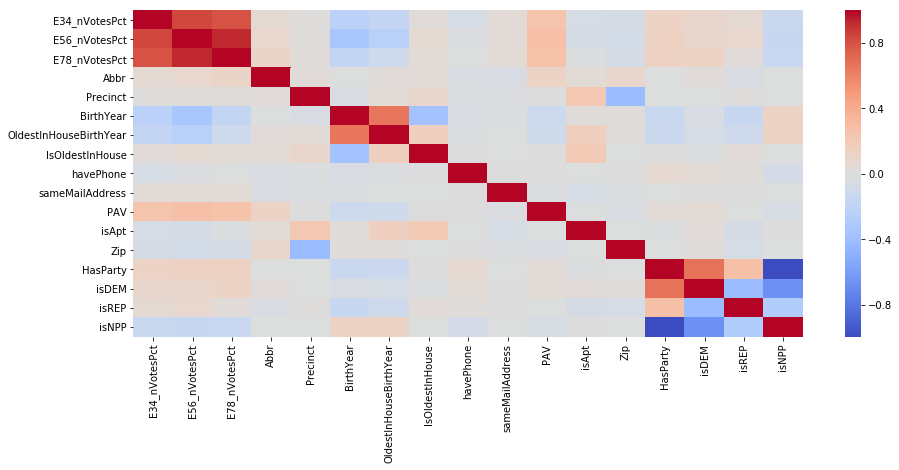

In [20]:
df = vote_data_plus_fields(['Abbr','Precinct','BirthYear','OldestInHouseBirthYear','IsOldestInHouse',
                            'havePhone','sameMailAddress','PAV','isApt','Zip','HasParty',
                            'isDEM','isREP','isNPP'],
                            inc_HHvd = False, inc_Vid=False)
# converting PAV Y/N to True/False
df['PAV'] = df['PAV'].str.contains('Y')

# plot the heatmap
sns.heatmap(df.corr(), 
        xticklabels=df.corr().columns,
        yticklabels=df.corr().columns, cmap='coolwarm')
plt.show()

Correlations can be see with Permanent Absentee Ballots, and age (negative birthYear), also with having a party affiliation and negatively with being a No Party Preference.

In [21]:
df.corr()

,E34_nVotesPct,E56_nVotesPct,E78_nVotesPct,Abbr,Precinct,BirthYear,OldestInHouseBirthYear,IsOldestInHouse,havePhone,sameMailAddress,PAV,isApt,Zip,HasParty,isDEM,isREP,isNPP
E34_nVotesPct,1.000000,0.843985,0.804988,0.061162,0.010929,-0.228068,-0.175615,0.027021,-0.052187,0.034408,0.253559,-0.046606,-0.055593,0.134130,0.088697,0.063795,-0.135627
E56_nVotesPct,0.843985,1.000000,0.937424,0.081047,0.017089,-0.327751,-0.239807,0.057924,-0.016199,0.038338,0.282039,-0.058249,-0.070970,0.147570,0.091782,0.082165,-0.148844
E78_nVotesPct,0.804988,0.937424,1.000000,0.115448,0.021054,-0.170714,-0.100923,0.035346,-0.000426,0.047737,0.264846,-0.012920,-0.054879,0.139722,0.124154,0.028617,-0.140250
Abbr,0.061162,0.081047,0.115448,1.000000,0.030848,-0.000566,0.027531,0.037651,-0.028249,-0.035555,0.130060,0.046193,0.095783,0.000406,0.026616,-0.033653,-0.000326
Precinct,0.010929,0.017089,0.021054,0.030848,1.000000,-0.030181,0.043500,0.088935,-0.010321,-0.019754,0.006783,0.227459,-0.418098,-0.001257,-0.003371,0.012132,0.000423
BirthYear,-0.228068,-0.327751,-0.170714,-0.000566,-0.030181,1.000000,0.660768,-0.365598,-0.036274,-0.019242,-0.114379,0.022714,0.024202,-0.130194,-0.035936,-0.149292,0.128147
OldestInHouseBirthYear,-0.175615,-0.239807,-0.100923,0.027531,0.043500,0.660768,1.000000,0.163700,-0.015668,-0.000947,-0.097358,0.165752,0.012582,-0.124105,-0.051586,-0.103749,0.122805
IsOldestInHouse,0.027021,0.057924,0.035346,0.037651,0.088935,-0.365598,0.163700,1.000000,0.009351,-0.001746,0.008503,0.198518,-0.000394,0.005453,-0.009127,0.031765,-0.004791
havePhone,-0.052187,-0.016199,-0.000426,-0.028249,-0.010321,-0.036274,-0.015668,0.009351,1.000000,0.005897,0.004934,0.002252,0.007284,0.066768,0.041580,0.023659,-0.063468
sameMailAddress,0.034408,0.038338,0.047737,-0.035555,-0.019754,-0.019242,-0.000947,-0.001746,0.005897,1.000000,-0.018164,-0.045917,-0.014047,0.000492,0.004053,0.006234,-0.001307


## PAV voters

In [22]:
df = vote_data_plus_fields(['PAV'])
dfm = []
for key, grp in df.groupby(['PAV']):
    dfm.append(vote_rate_as_pct(grp, key))

N has:
    n = 3439 for E34 data
    n = 3707 for E56 data
    n = 4479 for E78 data
Y has:
    n = 5864 for E34 data
    n = 6336 for E56 data
    n = 7899 for E78 data


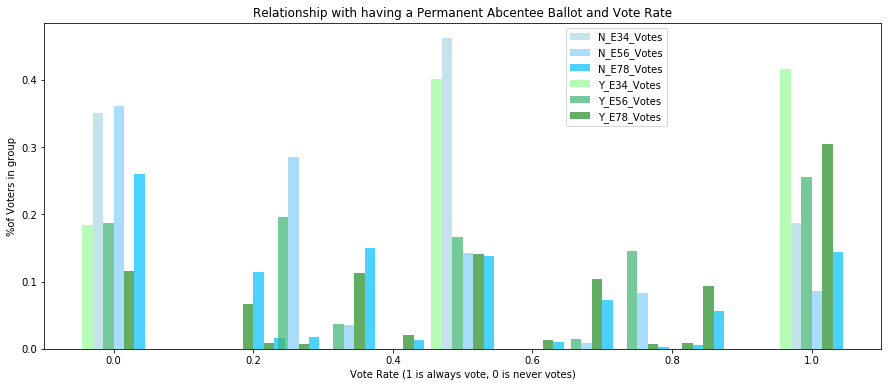

VoteRate,0.0,0.17,0.2,0.25,0.33,0.4,0.5,0.6,0.67,0.75,0.8,0.83,1.0
N_E34_Votes,0.351265,NaN,NaN,NaN,NaN,NaN,0.461762,NaN,NaN,NaN,NaN,NaN,0.186973
N_E56_Votes,0.360939,NaN,NaN,0.284866,0.035878,NaN,0.142163,NaN,0.008093,0.082547,NaN,NaN,0.085514
N_E78_Votes,0.259656,0.114758,0.016522,0.017191,0.150480,0.013619,0.137531,0.009600,0.073231,0.002456,0.005135,0.056486,0.143336
Y_E34_Votes,0.183322,NaN,NaN,NaN,NaN,NaN,0.401432,NaN,NaN,NaN,NaN,NaN,0.415246
Y_E56_Votes,0.186553,NaN,NaN,0.195234,0.036774,NaN,0.166193,NaN,0.014362,0.145202,NaN,NaN,0.255682
Y_E78_Votes,0.115331,0.066844,0.008862,0.006710,0.112799,0.020889,0.140271,0.012407,0.103304,0.006710,0.008229,0.093809,0.303836


In [23]:
title = 'Relationship with having a Permanent Abcentee Ballot and Vote Rate'
plot_always_never_only = False

if plot_always_never_only:
    # plot of always and never voters only:
    tdf = [d.loc[[0,1],:] for d in dfm]
    plot_groups(tdf, title)
else:
    # plot of all vote rates:
    plot_groups(dfm, title)
    
pd.concat([d for d in dfm], axis=1, sort=True).transpose()

Having a permanent Absentee Ballot significantly increases the likelihood of your being in the always voter category.

## Gender

In [24]:
df = vote_data_plus_fields(['Gender'])
df.Gender = df.Gender.cat.remove_categories('UNK')

#df.groupby(['Gender']).describe()

dfm = []
for key, grp in df.groupby(['Gender']):
    dfm.append(vote_rate_as_pct(grp, key))

F has:
    n = 4455 for E34 data
    n = 4740 for E56 data
    n = 5651 for E78 data
M has:
    n = 4084 for E34 data
    n = 4355 for E56 data
    n = 5269 for E78 data


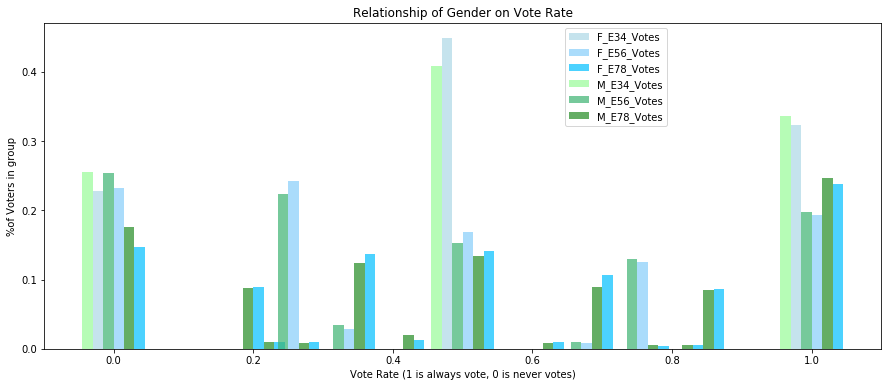

VoteRate,0.0,0.17,0.2,0.25,0.33,0.4,0.5,0.6,0.67,0.75,0.8,0.83,1.0
F_E34_Votes,0.227834,NaN,NaN,NaN,NaN,NaN,0.448485,NaN,NaN,NaN,NaN,NaN,0.323681
F_E56_Votes,0.232068,NaN,NaN,0.242194,0.028903,NaN,0.168987,NaN,0.009072,0.125316,NaN,NaN,0.193460
F_E78_Votes,0.146346,0.089011,0.010441,0.010087,0.137321,0.012918,0.141037,0.010264,0.106707,0.004601,0.006017,0.086710,0.238542
M_E34_Votes,0.255632,NaN,NaN,NaN,NaN,NaN,0.408668,NaN,NaN,NaN,NaN,NaN,0.335700
M_E56_Votes,0.253731,NaN,NaN,0.223881,0.034214,NaN,0.152468,NaN,0.009185,0.129047,NaN,NaN,0.197474
M_E78_Votes,0.175555,0.087493,0.010249,0.008920,0.124502,0.019548,0.133422,0.008541,0.088821,0.004935,0.005694,0.085215,0.247106


In [25]:
title = 'Relationship of Gender on Vote Rate'
plot_always_never_only = False

if plot_always_never_only:
    # plot of always and never voters only:
    tdf = [d.loc[[0,1],:] for d in dfm]
    plot_groups(tdf, title)
else:
    # plot of all vote rates:
    plot_groups(dfm, title)
    
pd.concat([d for d in dfm], axis=1, sort=True).transpose()

Interestingly Females are less likely to be in the Always voter and less likely to be in the Never vote group than males by just a couple of percentage points!

## BirthState Region
Excluding Californians

In [26]:
df = vote_data_plus_fields(['BirthPlaceState','BirthPlaceStateRegion'])

# Removing Voters born in California
df.loc[df.BirthPlaceState == 'California', 'BirthPlaceStateRegion'] = np.NaN
df = df.drop('BirthPlaceState', axis=1)
#df.BirthPlaceStateRegion.value_counts()

dfm = []
#df.groupby(['BirthPlaceStateRegion']).describe()
for key, grp in df.groupby('BirthPlaceStateRegion'):
    dfm.append(vote_rate_as_pct(grp, key))

MidWest has:
    n = 503 for E34 data
    n = 527 for E56 data
    n = 584 for E78 data
NorthWest has:
    n = 360 for E34 data
    n = 373 for E56 data
    n = 429 for E78 data
South has:
    n = 367 for E34 data
    n = 380 for E56 data
    n = 420 for E78 data
West has:
    n = 368 for E34 data
    n = 381 for E56 data
    n = 434 for E78 data


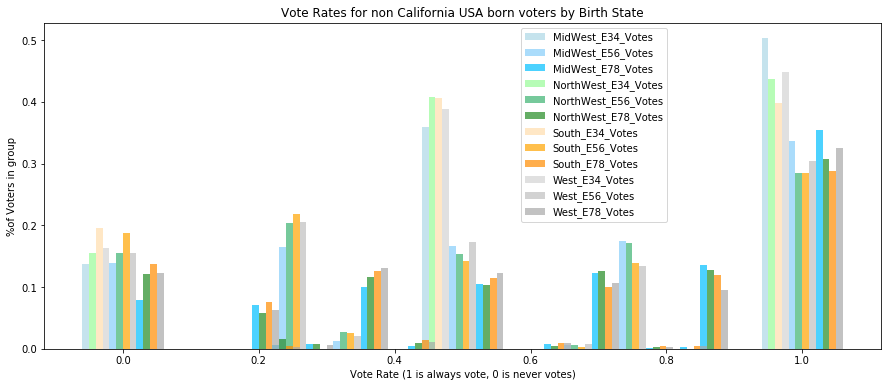

,0.0,0.17,0.2,0.25,0.33,0.4,0.5,0.6,0.67,0.75,0.8,0.83,1.0
MidWest_E34_Votes,0.137177,NaN,NaN,NaN,NaN,NaN,0.359841,NaN,NaN,NaN,NaN,NaN,0.502982
MidWest_E56_Votes,0.138520,NaN,NaN,0.165085,0.013283,NaN,0.166983,NaN,0.005693,0.174573,NaN,NaN,0.335863
MidWest_E78_Votes,0.078767,0.070205,0.006849,0.008562,0.099315,0.005137,0.104452,0.008562,0.123288,0.001712,0.003425,0.135274,0.354452
NorthWest_E34_Votes,0.155556,NaN,NaN,NaN,NaN,NaN,0.408333,NaN,NaN,NaN,NaN,NaN,0.436111
NorthWest_E56_Votes,0.155496,NaN,NaN,0.203753,0.026810,NaN,0.152815,NaN,0.005362,0.171582,NaN,NaN,0.284182
NorthWest_E78_Votes,0.121212,0.058275,0.016317,0.006993,0.116550,0.009324,0.102564,0.004662,0.125874,0.002331,NaN,0.128205,0.307692
South_E34_Votes,0.196185,NaN,NaN,NaN,NaN,NaN,0.405995,NaN,NaN,NaN,NaN,NaN,0.397820
South_E56_Votes,0.186842,NaN,NaN,0.218421,0.026316,NaN,0.142105,NaN,0.002632,0.139474,NaN,NaN,0.284211
South_E78_Votes,0.138095,0.076190,0.004762,NaN,0.126190,0.014286,0.114286,0.009524,0.100000,0.004762,0.004762,0.119048,0.288095
West_E34_Votes,0.163043,NaN,NaN,NaN,NaN,NaN,0.388587,NaN,NaN,NaN,NaN,NaN,0.448370


In [27]:
title = 'Vote Rates for non California USA born voters by Birth State'
plot_always_never_only = False

if plot_always_never_only:
    # plot of always and never voters only:
    tdf = [d.loc[[0,1],:] for d in dfm]
    plot_groups(tdf, title)
else:
    # plot of all vote rates:
    plot_groups(dfm, title)
    
pd.concat([d for d in dfm], axis=1, sort=True).transpose()

There doesn't seem to be a strong pattern for voting behavior for people born out of CA, grouped by birth region.
West and MidWest born voters are slightly more likely to end up in the always vote category than Southern born voters.

## BirthCountry

In [28]:
df = vote_data_plus_fields(['BirthPlaceCountry','BirthPlaceCountryRegion'])

print(df.BirthPlaceCountryRegion.value_counts())

# removing Oceania and Africa as sample size is too small
df['BirthPlaceCountryRegion'].replace('Africa', np.NaN, inplace=True)
df['BirthPlaceCountryRegion'].replace('Oceania', np.NaN, inplace=True)
df = df.drop('BirthPlaceCountry', axis=1)

df['BirthPlaceCountryRegion'].replace('USA', 'A_USA', inplace=True)

USA         7074
Asia        3915
Americas     551
Europe       291
Africa        88
Oceania       59
Name: BirthPlaceCountryRegion, dtype: int64


In [29]:
dfm = []
df.groupby(['BirthPlaceCountryRegion']).describe()
for key, grp in df.groupby(['BirthPlaceCountryRegion']):
    dfm.append(vote_rate_as_pct(grp, key))

A_USA has:
    n = 5302 for E34 data
    n = 5627 for E56 data
    n = 6741 for E78 data
Americas has:
    n = 428 for E34 data
    n = 452 for E56 data
    n = 529 for E78 data
Asia has:
    n = 2634 for E34 data
    n = 2935 for E56 data
    n = 3615 for E78 data
Europe has:
    n = 232 for E34 data
    n = 247 for E56 data
    n = 276 for E78 data


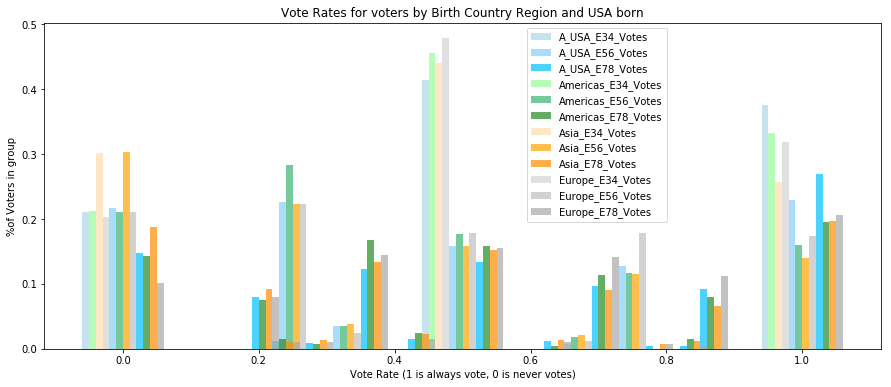

VoteRate,0.0,0.17,0.2,0.25,0.33,0.4,0.5,0.6,0.67,0.75,0.8,0.83,1.0
A_USA_E34_Votes,0.210864,NaN,NaN,NaN,NaN,NaN,0.413806,NaN,NaN,NaN,NaN,NaN,0.375330
A_USA_E56_Votes,0.216279,NaN,NaN,0.226586,0.035365,NaN,0.157811,NaN,0.007464,0.127955,NaN,NaN,0.228541
A_USA_E78_Votes,0.147308,0.080552,0.012016,0.008752,0.122682,0.015576,0.134253,0.012164,0.096128,0.004450,0.004450,0.092568,0.269100
Americas_E34_Votes,0.212617,NaN,NaN,NaN,NaN,NaN,0.455607,NaN,NaN,NaN,NaN,NaN,0.331776
Americas_E56_Votes,0.210177,NaN,NaN,0.283186,0.035398,NaN,0.176991,NaN,0.017699,0.117257,NaN,NaN,0.159292
Americas_E78_Votes,0.143667,0.075614,0.015123,0.007561,0.168242,0.024575,0.158790,0.003781,0.113422,NaN,0.015123,0.079395,0.194707
Asia_E34_Votes,0.302202,NaN,NaN,NaN,NaN,NaN,0.440395,NaN,NaN,NaN,NaN,NaN,0.257403
Asia_E56_Votes,0.302555,NaN,NaN,0.223169,0.038842,NaN,0.158773,NaN,0.020784,0.115503,NaN,NaN,0.140375
Asia_E78_Votes,0.186999,0.092669,0.010788,0.014108,0.133610,0.023237,0.151867,0.013278,0.090456,0.008022,0.011895,0.066390,0.196680
Europe_E34_Votes,0.202586,NaN,NaN,NaN,NaN,NaN,0.478448,NaN,NaN,NaN,NaN,NaN,0.318966


In [30]:
title = 'Vote Rates for voters by Birth Country Region and USA born'
plot_always_never_only = False

if plot_always_never_only:
    # plot of always and never voters only:
    tdf = [d.loc[[0,1],:] for d in dfm]
    plot_groups(tdf, title)
else:
    # plot of all vote rates:
    plot_groups(dfm, title)
    
pd.concat([d for d in dfm], axis=1, sort=True).transpose()

Voters born in Asia are more likely to end up in the never vote category. 
USA born voters are more likely to be in the Always vote category.

## CityArea

In [31]:
df = vote_data_plus_fields(['CityArea'])

print('Removing {} cityarea as our data only has {} voters in that area'.format(
df.CityArea.value_counts().index[-1],df.CityArea.value_counts()[-1]))

df['CityArea'].replace('Niles', np.NaN, inplace=True)

dfm = []
for key, grp in df.groupby(['CityArea']):
    dfm.append(vote_rate_as_pct(grp, key))

Removing Niles cityarea as our data only has 3 voters in that area
Centerville has:
    n = 6508 for E34 data
    n = 7014 for E56 data
    n = 8612 for E78 data
Downtown / BART has:
    n = 2792 for E34 data
    n = 3026 for E56 data
    n = 3763 for E78 data


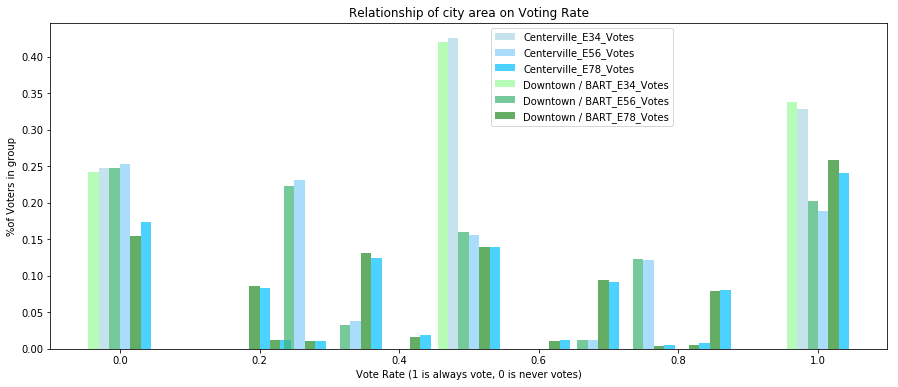

VoteRate,0.0,0.17,0.2,0.25,0.33,0.4,0.5,0.6,0.67,0.75,0.8,0.83,1.0
Centerville_E34_Votes,0.247081,NaN,NaN,NaN,NaN,NaN,0.425169,NaN,NaN,NaN,NaN,NaN,0.327750
Centerville_E56_Votes,0.252638,NaN,NaN,0.230539,0.038067,NaN,0.156259,NaN,0.012261,0.121614,NaN,NaN,0.188623
Centerville_E78_Votes,0.173595,0.083720,0.011496,0.010451,0.124361,0.019392,0.139224,0.011844,0.091500,0.005574,0.008128,0.080469,0.240246
Downtown / BART_E34_Votes,0.241762,NaN,NaN,NaN,NaN,NaN,0.420129,NaN,NaN,NaN,NaN,NaN,0.338109
Downtown / BART_E56_Votes,0.247191,NaN,NaN,0.223397,0.032716,NaN,0.159617,NaN,0.011566,0.122935,NaN,NaN,0.202578
Downtown / BART_E78_Votes,0.153867,0.085304,0.011959,0.010630,0.131278,0.015679,0.139251,0.010364,0.094605,0.004252,0.004783,0.079724,0.258305


In [32]:
title = 'Relationship of city area on Voting Rate'
plot_always_never_only = False

if plot_always_never_only:
    # plot of always and never voters only:
    tdf = [d.loc[[0,1],:] for d in dfm]
    plot_groups(tdf, title)
else:
    # plot of all vote rates:
    plot_groups(dfm, title)
    
pd.concat([d for d in dfm], axis=1, sort=True).transpose()

Voters in Centerville are a little more likely to end up in the never vote category and Downtown/BART voters in the always vote category. The effect is small and may not be real.

## Living in an Apartment

In [33]:
df = vote_data_plus_fields(['isApt'])
dfm = []
pre = ['House', 'Appartment']
for key, grp in df.groupby(['isApt']):
    dfm.append(vote_rate_as_pct(grp, pre[key]))

House has:
    n = 7727 for E34 data
    n = 8262 for E56 data
    n = 9906 for E78 data
Appartment has:
    n = 1576 for E34 data
    n = 1781 for E56 data
    n = 2472 for E78 data


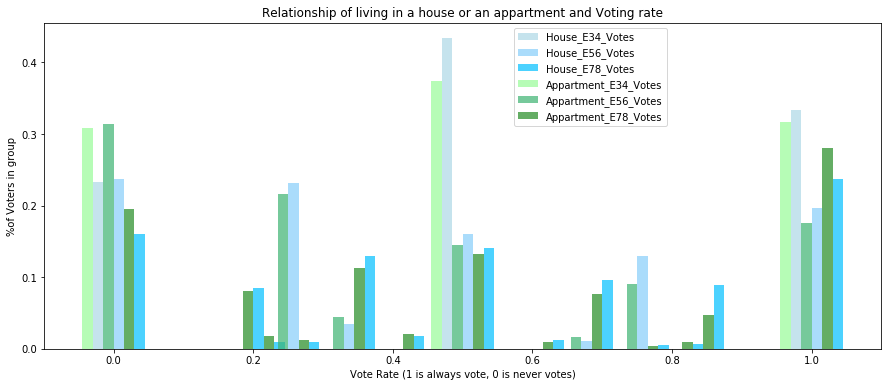

VoteRate,0.0,0.17,0.2,0.25,0.33,0.4,0.5,0.6,0.67,0.75,0.8,0.83,1.0
House_E34_Votes,0.232432,NaN,NaN,NaN,NaN,NaN,0.433804,NaN,NaN,NaN,NaN,NaN,0.333765
House_E56_Votes,0.237352,NaN,NaN,0.231058,0.034858,NaN,0.160131,NaN,0.011014,0.129024,NaN,NaN,0.196563
House_E78_Votes,0.160711,0.084898,0.010095,0.009893,0.129820,0.017666,0.141026,0.012013,0.096305,0.005451,0.006360,0.088532,0.237230
Appartment_E34_Votes,0.309010,NaN,NaN,NaN,NaN,NaN,0.374365,NaN,NaN,NaN,NaN,NaN,0.316624
Appartment_E56_Votes,0.313869,NaN,NaN,0.215609,0.043796,NaN,0.144301,NaN,0.016844,0.089837,NaN,NaN,0.175744
Appartment_E78_Votes,0.194984,0.081311,0.017799,0.012945,0.112864,0.020631,0.132282,0.008900,0.076861,0.004045,0.010113,0.047330,0.279935


In [34]:
title = 'Relationship of living in a house or an appartment and Voting rate'
plot_always_never_only = False

if plot_always_never_only:
    # plot of always and never voters only:
    tdf = [d.loc[[0,1],:] for d in dfm]
    plot_groups(tdf, title)
else:
    # plot of all vote rates:
    plot_groups(dfm, title)
    
pd.concat([d for d in dfm], axis=1, sort=True).transpose()

There isn't any clear relationship between a voters house type and their voting rate, it is interesting to notice that voters living in Apartments seem a little more likely to be in the never voter category, however in the most recent election cycle they are also more likely to be in the always vote group!

## Exploring how MailCountry is related to voting behavior



In [35]:
df = vote_data_plus_fields(['MailCountry'])
for_other=['GERMANY', 'JAPAN', 'THAILAND', 'ISRAEL', 'PHILIPPINES', 'CHINA', 'MYANMAR',
           'HONG KONG','TAIWAN', 'AUSTRALIA', 'SERBIA', 'SINGAPORE', 'SPAIN','GHANA', 
           'COSTA RICA', 'AUSTRIA', 'CHILE', 'LEBANON','GREECE', 'UNITED KINGDOM', 'MEXICO',
           'NEW ZEALAND','PAKISTAN', 'PERU', 'SWITZERLAND', 'ARGENTINA']
df['MC_Main'] = df.loc[df.MailCountry.notnull(),'MailCountry'].astype(str)
df.loc[df.MC_Main.isin(for_other) == True,['MC_Main']] = 'ZTHER'
df = df.drop('MailCountry', axis=1)

#df.MC_Main.value_counts()

dfm = []
df.groupby(['MC_Main']).describe()
for key, grp in df.groupby(['MC_Main']):
    dfm.append(vote_rate_as_pct(grp, key))

CANADA has:
    n = 11 for E34 data
    n = 12 for E56 data
    n = 13 for E78 data
INDIA has:
    n = 22 for E34 data
    n = 23 for E56 data
    n = 27 for E78 data
USA has:
    n = 233 for E34 data
    n = 253 for E56 data
    n = 329 for E78 data
ZTHER has:
    n = 34 for E34 data
    n = 35 for E56 data
    n = 49 for E78 data


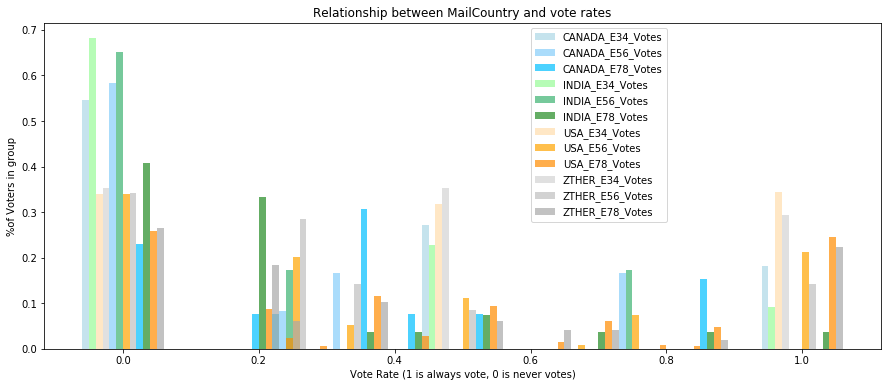

,0.0,0.17,0.2,0.25,0.33,0.4,0.5,0.6,0.67,0.75,0.8,0.83,1.0
CANADA_E34_Votes,0.545455,NaN,NaN,NaN,NaN,NaN,0.272727,NaN,NaN,NaN,NaN,NaN,0.181818
CANADA_E56_Votes,0.583333,NaN,NaN,0.083333,0.166667,NaN,NaN,NaN,NaN,0.166667,NaN,NaN,NaN
CANADA_E78_Votes,0.230769,0.076923,0.076923,NaN,0.307692,0.076923,0.076923,NaN,NaN,NaN,NaN,0.153846,NaN
INDIA_E34_Votes,0.681818,NaN,NaN,NaN,NaN,NaN,0.227273,NaN,NaN,NaN,NaN,NaN,0.090909
INDIA_E56_Votes,0.652174,NaN,NaN,0.173913,NaN,NaN,NaN,NaN,NaN,0.173913,NaN,NaN,NaN
INDIA_E78_Votes,0.407407,0.333333,NaN,NaN,0.037037,0.037037,0.074074,NaN,0.037037,NaN,NaN,0.037037,0.037037
USA_E34_Votes,0.339056,NaN,NaN,NaN,NaN,NaN,0.317597,NaN,NaN,NaN,NaN,NaN,0.343348
USA_E56_Votes,0.339921,NaN,NaN,0.201581,0.051383,NaN,0.110672,NaN,0.007905,0.075099,NaN,NaN,0.213439
USA_E78_Votes,0.258359,0.088146,0.024316,0.006079,0.115502,0.027356,0.094225,0.015198,0.060790,0.009119,0.006079,0.048632,0.246201
ZTHER_E34_Votes,0.352941,NaN,NaN,NaN,NaN,NaN,0.352941,NaN,NaN,NaN,NaN,NaN,0.294118


In [36]:
title = 'Relationship between MailCountry and vote rates'
plot_always_never_only = False

if plot_always_never_only:
    # plot of always and never voters only:
    tdf = [d.loc[['0.0','1.0'],:] for d in dfm]
    plot_groups(tdf, title)
else:
    # plot of all vote rates:
    plot_groups(dfm, title)

pd.concat([d for d in dfm], axis=1, sort=True).transpose()

Voters with mailing address' outside the USA ie are actually voting from overseas, are more likely to end up in the never vote category. Particularly if your mailing address is in India you have between a 40 and 68% chance of being a never voter!

This data is on a very small sample size and so is not statistically robust.

## Exploring how RegDate and RegDateOriginal affect vote behavior

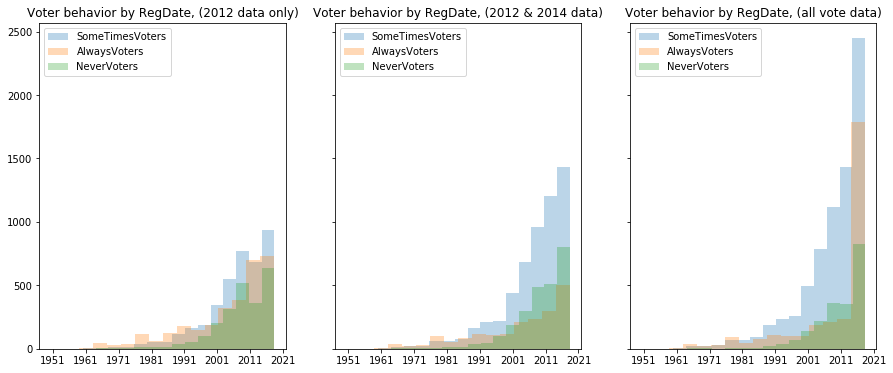

In [37]:
df = vote_data_plus_fields(['RegDate'])

fig, (ax1,ax2,ax3) = plt.subplots(1,3, sharey=True)
ax1 = plot_hist_vote_rate_vs_field(ax1, df, 'E34_nVotesPct', 'RegDate')
ax1.set_title('Voter behavior by RegDate, (2012 data only)')

ax2 = plot_hist_vote_rate_vs_field(ax2, df, 'E56_nVotesPct', 'RegDate')
ax2.set_title('Voter behavior by RegDate, (2012 & 2014 data)')

ax3 = plot_hist_vote_rate_vs_field(ax3, df, 'E78_nVotesPct', 'RegDate')
ax3.set_title('Voter behavior by RegDate, (all vote data)')

plt.show()

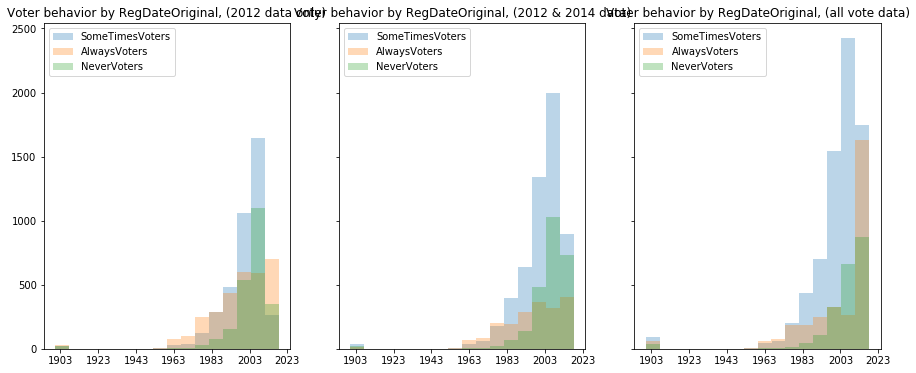

In [38]:
df = vote_data_plus_fields(['RegDateOriginal'])

fig, (ax1,ax2,ax3) = plt.subplots(1,3, sharey=True)
ax1 = plot_hist_vote_rate_vs_field(ax1, df, 'E34_nVotesPct', 'RegDateOriginal')
ax1.set_title('Voter behavior by RegDateOriginal, (2012 data only)')

ax2 = plot_hist_vote_rate_vs_field(ax2, df, 'E56_nVotesPct', 'RegDateOriginal')
ax2.set_title('Voter behavior by RegDateOriginal, (2012 & 2014 data)')

ax3 = plot_hist_vote_rate_vs_field(ax3, df, 'E78_nVotesPct', 'RegDateOriginal')
ax3.set_title('Voter behavior by RegDateOriginal, (all vote data)')

plt.show()

Never voters seem to have slightly closer RegDates although this could just be the affect of age, a voter would need to be older to have an older regDate which we've already established is correlated with a greater chance of voting.